In [74]:
import numpy as np
import pandas as pd
import matplotlib.ticker as tick
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def filter_df(df, cols, filters):
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

In [75]:
# Import data
data_path = '/Users/lukecullen/PycharmProjects/petrochemical-data/data/'

output_path = '/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/PhD/C-THRU/paper_2_finalisation/figures/'#'../analysis_outputs/'

#estimated_file = data_path+'combined/processConversionFactors_w_uncertainties.csv'
production_file = data_path+'processed/icisFacilityProduction.csv'

#colors = ['#E69973', '#CEE675', '#E56181', '#49E6DA', '#B455E6']
#colors = ['#E66070', '#E6A730', '#6EE588', '#498DE6', 'k', 'grey', 'purple']
colors = ['#d73027', '#91bfdb', '#4575b4', '#fc8d59']

In [76]:
# Emissions
#emissions = pd.read_csv(estimated_file)
data = pd.read_parquet('/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/PhD/Power_BI/input_data/country_summaries_dedoubled_unfiltered_unpivoted.parquet')

# Production
production = pd.read_csv(production_file, index_col=0)
year = '2020'

In [77]:
# Sort out misclassified benzene direct process emissions
bzd = filter_df(data, ['PRODUCT', 'Type'], [['Benzene'], ['Direct Process']])
bzd['y'], bzd['sigma_y'] = 0, 0
non_bzd = data[~((data['PRODUCT']=='Benzene') & (data['Type']=='Direct Process'))]
data = pd.concat((non_bzd, bzd)).reset_index(drop=True)

In [78]:
yearly_prod = production[['PRODUCT',year]].groupby('PRODUCT').sum().reset_index()

ifa_prod = pd.read_csv(data_path+'extracted/IFA_production_w_uncertainties.csv')[['PRODUCT', year]].groupby('PRODUCT').sum().reset_index()

name_conversions = {
    'NH3': 'AMMONIA',
    'AN': 'AMMONIUM NITRATE',
    'Ammonium nitrate (33.5-0-0) granulated': 'AMMONIUM NITRATE',
    'AS': 'AMMONIUM SULPHATE',
    'CAN': 'CALCIUM AMMONIUM NITRATE',
    'Calcium ammonium nitrate (27-0-0)': 'CALCIUM AMMONIUM NITRATE',
    'Urea (46-0-0)': 'UREA'
}

ifa_prod['PRODUCT'] = ifa_prod['PRODUCT'].replace(name_conversions)

total_prod = pd.concat((yearly_prod, ifa_prod)).sort_values('PRODUCT').reset_index(drop=True)

product_grouping = pd.read_csv(data_path+'extra_inputs/product_groups.csv', index_col=0)
product_grouping = product_grouping.dropna(subset=['Product group']).reset_index(drop=True)
grouped_prod = pd.merge(total_prod, product_grouping, on='PRODUCT', how='left').groupby('Product group').sum()

total_prod['PRODUCT'] = total_prod['PRODUCT'].str.title()
prod_capitals = {'Dmt':'DMT', 'Abs':'ABS', 'Eva Copolymers':'EVA Copolymers', 'Expandable Ps':'Expandable PS', 'Hdpe':'HDPE', 'Ldpe':'LDPE', 'Lldpe':'LLDPE', 'Pam Resins (6+66)':'PAM Resins (6+66)', 'Pet Resins':'PET Resins', 'Pvc':'PVC', 'Nb Copolymers':'NB Copolymers', 'Sb Latices':'SB Latices', 'Sbr (Includes Sbcs)':'SBR (Includes SBCs)', 'Vinyl Acetate M.':'Vinyl Acetate','Hmda':'HMDA', 'Mtbe':'MTBE', 'Pta':'PTA', 'Mdi':'MDI', 'Tdi':'TDI'}
total_prod['PRODUCT'] = total_prod['PRODUCT'].replace(prod_capitals)

In [79]:
## Get intermediates factors
data_filt = filter_df(data, ['Gas', 'Type', 'Year', 'Region', 'Product type'], [['CO₂e - 100yr'], ['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use', 'Primary chemicals', 'Organic chemicals', 'Other intermediates'], [int(year)], ['World'], ['Intermediates']])

data_filt = data_filt.groupby(['Region', 'COUNTRY/TERRITORY', 'Product group', 'PRODUCT', 'Gas', 'Product type', 'Year','Type']).sum().reset_index()

In [80]:
# Intermediate product group plotting
factors_int = data_filt[data_filt['Product group']!=data_filt['Type']]
factors_int = factors_int.pivot(index=['Region', 'COUNTRY/TERRITORY', 'Product group', 'PRODUCT', 'Gas', 'Product type', 'Year'], columns='Type', values=['sigma_y', 'y'])
subset_int = data_filt.groupby(['Product group', 'Type']).sum().reset_index()
totals = subset_int.groupby('Product group').sum().reset_index()
subset_int = subset_int.merge(totals, on='Product group')
subset_int['ratio'] = subset_int['y_x']/subset_int['y_y']
int_ratios = subset_int[['Product group', 'Type_x', 'ratio']].set_index(['Product group', 'Type_x'])
# factors_acc = factors_int.copy()
# for col in intermediate_groups:
#     col_vals = factors_acc[('y', col)]
#     for source in source_groups:
#         factors_acc[('y', source)] = factors_acc[('y', source)]+factors_acc[('y', col)]*pg_source_ratios.loc[(col, source)].values[0]

# Individual products plotting

factors = data_filt.pivot(index=['Region', 'COUNTRY/TERRITORY', 'Product group', 'PRODUCT', 'Gas', 'Product type', 'Year'], columns='Type', values=['sigma_y', 'y'])

intermediate_groups = ['Primary chemicals', 'Organic chemicals', 'Other intermediates']
source_groups = ['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use']

subset = data_filt.groupby(['Product group', 'Type']).sum().reset_index()
subset = filter_df(subset, ['Product group', 'Type'], [intermediate_groups, source_groups])
totals = subset.groupby('Product group').sum().reset_index()
subset = subset.merge(totals, on='Product group')
subset['ratio'] = subset['y_x']/subset['y_y']
pg_source_ratios = subset[['Product group', 'Type_x', 'ratio']].set_index(['Product group', 'Type_x'])

factors_acc = factors.copy()
for col in intermediate_groups:
    col_vals = factors_acc[('y', col)]
    for source in source_groups:
        factors_acc[('y', source)] = factors_acc[('y', source)]+factors_acc[('y', col)]*pg_source_ratios.loc[(col, source)].values[0]

In [81]:
## Get downstream factors

data_filt_ds = filter_df(data, ['Gas', 'Type', 'Year', 'Region', 'Product type'], [['CO₂e - 100yr'], ['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use', 'Primary chemicals', 'Organic chemicals', 'Other intermediates'], [int(year)], ['World'], ['Downstream']])

factors_ds = data_filt_ds[data_filt_ds['Product group']!=data_filt_ds['Type']]
factors_ds = factors_ds.pivot(index=['Region', 'COUNTRY/TERRITORY', 'Product group', 'PRODUCT', 'Gas', 'Product type', 'Year'], columns='Type', values=['sigma_y', 'y'])
# subset_int = data_filt.groupby(['Product group', 'Type']).sum().reset_index()
# totals = subset_int.groupby('Product group').sum().reset_index()
# subset_int = subset_int.merge(totals, on='Product group')
# subset_int['ratio'] = subset_int['y_x']/subset_int['y_y']
# int_ratios = subset_int[['Product group', 'Type', 'ratio']].set_index(['Product group', 'Type'])

# source_groups = ['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use']+['Primary chemicals', 'Organic chemicals', 'Other intermediates']
#
# subset = data_filt_ds.groupby(['Product group', 'Type']).sum().reset_index()
# subset = filter_df(subset, ['Type'], [source_groups])
# totals = subset.groupby('Product group').sum().reset_index()
# subset = subset.merge(totals, on='Product group')
# subset['ratio'] = subset['y_x']/subset['y_y']
# pg_source_ratios = subset[['Product group', 'Type', 'ratio']].set_index(['Product group', 'Type'])

# for col in source_groups:
#     col_vals = factors_ds_acc[('y', col)]
# for source in source_groups:
#     factors_ds_acc[('y', source)] = factors_ds_acc[('y', source)]+factors_ds_acc[('y', col)]*pg_source_ratios.loc[(col, source)].values[0]

In [9]:
group_type='Product group'
# columns=columns
factors = factors_int.copy()
type='y'
prod=grouped_prod.copy()

if columns is None:
    columns = ['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use']

if group_type == 'PRODUCT':
    group_cols = ['Product type', 'Product group', 'PRODUCT']
else: group_cols = ['Product type', 'Product group']

used_emissions = factors[type].reset_index().groupby(group_cols).sum().reset_index().drop(columns=['Year'])
used_emissions = used_emissions.merge(prod, on=group_type, how='left')

NameError: name 'columns' is not defined

In [82]:
def create_groupings(factors, prod, type='y', columns=None, group_type='PRODUCT'):

    if columns is None:
        columns = ['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use']

    if group_type == 'PRODUCT':
        group_cols = ['Product type', 'Product group', 'PRODUCT']
    else: group_cols = ['Product type', 'Product group']

    used_emissions = factors[type].reset_index().groupby(group_cols).sum().reset_index().drop(columns=['Year'])
    used_emissions = used_emissions.merge(prod, on=group_type, how='left')

    prod_grouping = used_emissions.copy()
    prod_grouping['Total_val'] = np.sum(used_emissions[columns], axis=1)

    for col in columns:
        prod_grouping[col] = prod_grouping[col]/prod_grouping[year]
    prod_grouping['Total_factor'] = np.sum(prod_grouping[columns], axis=1)

    type_grouping = used_emissions.groupby(['Product type', 'Product group']).sum().reset_index()
    type_grouping['Total_val'] = np.sum(type_grouping[columns], axis=1)
    for col in columns:
        type_grouping[col] = type_grouping[col]/type_grouping[year]
    type_grouping['Total_factor'] = np.sum(type_grouping[columns], axis=1)

    return prod_grouping, type_grouping

In [83]:
def plot_boxes(df, columns, colors, plot_col='Product group', err=True, scale_factor=1/1000, unit='Mt', firstword=False,
               ylabel1='Unit CO$_{2e}$ emissions ', ylabel2='CO$_{2e}$ emissions', plot_bars=True, labelling=True):
    index = range(len(df))
    plt.rcParams.update({'font.size':fontsize})

    values = [df[col] for col in columns]
    labels = columns #['Direct Process', 'Feedstock', 'Direct Energy Use', 'Indirect Energy Use']
    #colors = ['C1', 'C2', 'c', 'C4', 'C5', 'C6', 'C7']

    if plot_bars:
        ax2 = ax.twinx()

    for enum, (y, z, c) in enumerate(zip(values, labels, colors)):
        pos_bottom = np.sum(np.array(values[:enum]).clip(0), axis=0) if enum > 0 else None
        neg_bottom = np.sum(np.array(values[:enum]).clip(max=0), axis=0) if enum > 0 else None
        bottom = [pos_bottom[num] if val>=0 else neg_bottom[num] for num, val in enumerate(y)] if enum > 0 else None
        p1 = ax.bar(df['Centres']*scale_factor, y, width=df[year]*scale_factor, bottom=bottom, label=z, color=c, alpha=0.96, edgecolor='k')

        ax.xaxis.set_major_formatter(tick.StrMethodFormatter('{x:,.0f}'))

        if plot_bars:
            if err:
                p2 = ax2.errorbar(df['Centres']*scale_factor, df['Total_val_x']*scale_factor, yerr=df['Total_val_y']*scale_factor, fmt='o', color='b', ecolor='k', capsize=5, label='Total')
            else:
                p2 = ax2.scatter(df['Centres']*scale_factor, df['Total_val']*scale_factor, color='b', marker='o', edgecolors='k', label='Absolute uncertainty')
                p2 = ax.scatter(1, 1, color='b', marker='o', edgecolors='k', label='Absolute uncertainty')
                # for i, label in enumerate(df['Total_val']*scale_factor):
                #     ax2.annotate(label, ((df['Centres']*scale_factor)[i], (df['Total_val']*scale_factor)[i]), textcoords="offset points", xytext=(0,10), ha='center')
            ax2.tick_params(axis='y', labelcolor='blue', color='blue')
            ax2.spines['right'].set_color('blue')
            ax2.set_ylim(bottom=0)
            ax2.set_ylabel(ylabel2+' ('+unit+')', color='b')
            ax2.grid(axis='y', linestyle='dashed', zorder=0)
        else: ax.grid(axis='y', linestyle='dashed', zorder=0)

        if labelling:
            if z==labels[-1]:
                if firstword:
                    ax.bar_label(p1, labels= [i.split(' ')[0] for i in df[plot_col]], rotation=0)
                else: ax.bar_label(p1, labels= [i[:2].upper() if i[:2] != 'Or' else i[:2].upper()+'\n' for i in df[plot_col]], rotation=0)

    ax.set_xlabel('Product Output ('+unit+')')
    ax.set_ylabel(ylabel1+'(kg CO$_{2e}$/kg)')
    return ax

## Uncertainties plot

## Plot C

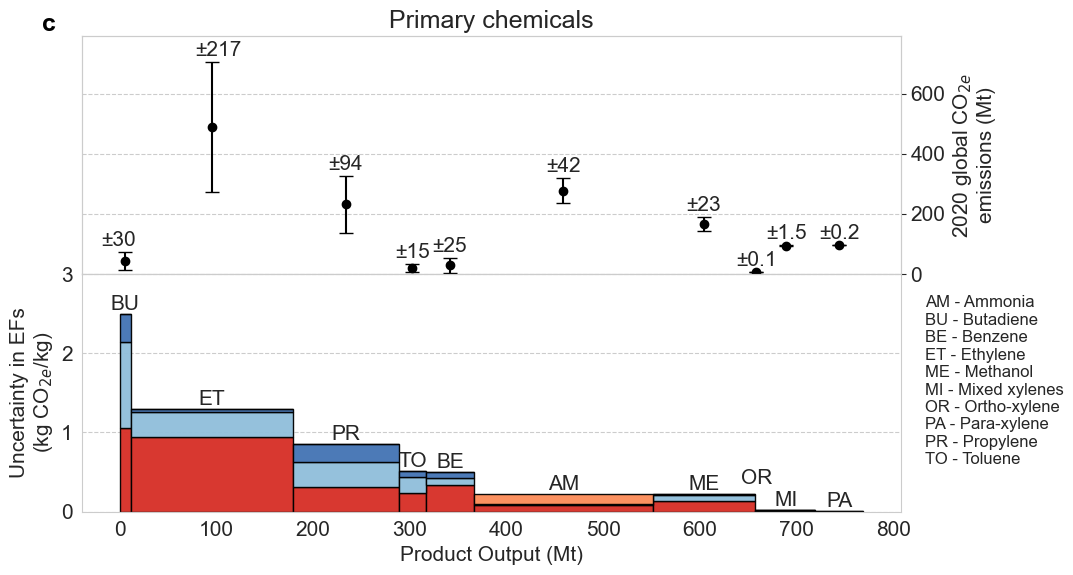

In [84]:
## Create production values figure
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [1, 1]}, figsize=[11,6], facecolor='white')

# colors = ['#E66070', '#E6A730', '#6EE588', '#498DE6', 'k', 'grey', 'purple']

width=0.7
fontsize=15

## Get total vals
ylabel1, ylabel2 = 'Uncertainty in EFs\n', '2020 global CO$_{2e}$\nemissions'

columns = ['Feedstock', 'Indirect Energy Use', 'Direct Energy Use', 'Direct Process']
used_prods = ['Ammonia', 'Butadiene', 'Benzene', 'Ethylene', 'Methanol', 'Propylene', 'Toluene', 'Mixed Xylenes', 'Ortho-Xylene', 'Para-Xylene']

prod_grouping, type_grouping = create_groupings(factors_acc, total_prod, 'y')
prod_grouping_s, type_grouping_s = create_groupings(factors_acc, total_prod, 'sigma_y')
prod_grouping = prod_grouping.merge(prod_grouping_s[['PRODUCT', 'Total_val', 'Total_factor']], on='PRODUCT')

individual_prods = filter_df(prod_grouping, ['PRODUCT'], [used_prods]).sort_values('Total_factor_x', ascending=False)
individual_prods['Cml'] = individual_prods[year].cumsum()
individual_prods['Centres'] = individual_prods['Cml']-individual_prods[year]/2

## Plot uncertainty boxes
ax = axs[1]
# Individual emissions
ind_prods = filter_df(prod_grouping_s, ['PRODUCT'], [used_prods]).sort_values('Total_factor', ascending=False)

ind_prods['Cml'] = ind_prods[year].cumsum()
ind_prods['Centres'] = ind_prods['Cml']-ind_prods[year]/2
ax = plot_boxes(ind_prods, columns, plot_col='PRODUCT', err=False, colors=colors, ylabel1=ylabel1, ylabel2=ylabel2, plot_bars=False)
axs[1].grid(False)
axs[1].grid(axis='y', linestyle='dashed', zorder=0)

#ax = plot_boxes(individual_prods, columns, colors=colors, plot_col='PRODUCT', plot_bars=False)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], labels[::-1], title='Life-cycle stage', bbox_to_anchor=[1, 1], fontsize=fontsize-1)
ax.text(1.03, 0.91, 'AM - Ammonia\nBU - Butadiene\nBE - Benzene\nET - Ethylene\nME - Methanol\nMI - Mixed xylenes\nOR - Ortho-xylene\nPA - Para-xylene\nPR - Propylene\nTO - Toluene', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox={'boxstyle':'round', 'linestyle':'-', 'facecolor':'w', 'alpha':0.5})
ax.set_ylim([0,3])
axs[0].grid(False)

## Create top bars
ax2 = axs[0].twinx()
df = ind_prods.merge(individual_prods, on='PRODUCT', how='left')
scale_factor=1/1000
unit='Mt'
p2 = ax2.errorbar(df['Centres_x']*scale_factor, df['Total_val_x']*scale_factor, yerr=df['Total_val_y']*scale_factor, fmt='o', color='k', ecolor='k', capsize=5, label='Total')
ax2.set_ylim(bottom=0)
ax2.set_ylabel(ylabel2+' ('+unit+')')
ax2.grid(False)
ax2.grid(axis='y', linestyle='dashed', zorder=0)
axs[0].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Add text annotations for each error bar
for i, (xi, yi, y_err_i) in enumerate(zip(df['Centres_x']*scale_factor, df['Total_val_x']*scale_factor, df['Total_val_y']*scale_factor)):
    x_loc=xi
    if i==0: x_loc = xi-7
    if i==1: x_loc = xi+7
    ax2.text(x_loc, yi + y_err_i + 20, '±'+f"{y_err_i:.0f}" if y_err_i > 9.49 else '±'+f"{y_err_i:.1f}", ha='center') #
ax2.set_ylim([0, 790])

ax2.set_title('Primary chemicals')
w, h, fs = -0.05, 1.1, 18
ax2.text(w, h, 'c', transform = ax2.transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

fig.tight_layout()

In [85]:
fig.savefig(output_path+'Figure_5c.png', bbox_inches='tight',dpi=300)
fig.savefig(output_path+'Figure_5c.eps', format='eps', bbox_inches='tight',dpi=300)

# Save figure
# fig.savefig('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/production_vs_emissions_uncert_individual_update.png', bbox_inches='tight',dpi=150)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [34]:
product_grouping = pd.read_csv(data_path+'extra_inputs/product_groups.csv', index_col=0)
product_grouping = product_grouping.dropna(subset=['Product group']).reset_index(drop=True)
grouped_prod = pd.merge(total_prod, product_grouping, on='PRODUCT', how='left').groupby('Product group').sum()

# oi_extraProd = 1/(1-(filter_df(data_filt, ['PRODUCT'], [['Propylene Glycol']])['y']/filter_df(data_filt, ['Product group'], [['Other intermediates']]).sum()['y'])).values
# grouped_prod.loc['Other intermediates', '2020'] = grouped_prod.loc['Other intermediates', '2020']*oi_extraProd
# 
# filt = factors_ds.reset_index()
# summary = filt[filt['Product group']=='Other downstream'][[('y')]].sum(axis=1)
# other_ds_prod_mult = summary.sum()/(summary.sum()-summary.iloc[0])
# grouped_prod.loc['Other downstream']['2020'] = grouped_prod.loc['Other downstream']['2020']*other_ds_prod_mult

In [35]:
## Add together organic chemicals and other intermediates product groups into a single group called Intermediates
factors_int_trial = factors_int.reset_index()
factors_int_trial['Product group'] = factors_int_trial['Product group'].replace({'Organic chemicals':'Intermediates', 'Other intermediates':'Intermediates'})
factors_int_trial = factors_int_trial.groupby(['Region', 'COUNTRY/TERRITORY', 'Product group', 'PRODUCT', 'Gas', 'Product type', 'Year']).sum().reset_index()

## Add ('y', 'organic chemicals') and ('y', 'other intermediates') columns into ('y', 'Primary chemicals') column and ('sigma_y', 'organic chemicals') and ('sigma_y', 'other intermediates') columns into ('sigma_y', 'Primary chemicals') column
factors_int_trial['y', 'Primary chemicals'] = factors_int_trial['y', 'Primary chemicals']+factors_int_trial['y', 'Organic chemicals']+factors_int_trial['y', 'Other intermediates']
factors_int_trial['sigma_y', 'Primary chemicals'] = factors_int_trial['sigma_y', 'Primary chemicals']+factors_int_trial['sigma_y', 'Organic chemicals']+factors_int_trial['sigma_y', 'Other intermediates']

factors_int_trial['y', 'Intermediates'] = factors_int_trial['y', 'Organic chemicals']*0
factors_int_trial['sigma_y', 'Intermediates'] = factors_int_trial['sigma_y', 'Organic chemicals']*0

## Remove the organic chemicals and other intermediates columns
factors_int_trial = factors_int_trial.drop(columns=[('y', 'Organic chemicals'), ('sigma_y', 'Organic chemicals'), ('y', 'Other intermediates'), ('sigma_y', 'Other intermediates')])

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_14332/2345846815.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  factors_int_trial = factors_int_trial.groupby(['Region', 'COUNTRY/TERRITORY', 'Product group', 'PRODUCT', 'Gas', 'Product type', 'Year']).sum().reset_index()


In [54]:
## Add together organic chemicals and other intermediates product groups into a single group called Intermediates for grouped_prod
grouped_prod_trial = grouped_prod.reset_index()
grouped_prod_trial['Product group'] = grouped_prod_trial['Product group'].replace({'Organic chemicals':'Intermediates', 'Other intermediates':'Intermediates'})
grouped_prod_trial = grouped_prod_trial.drop(columns=['Unnamed: 3', 'PRODUCT']).groupby(['Product group']).sum()

## Plot a

In [58]:
factors_int_used

sigma_y  \
Type                                                                                            Direct Energy Use   
Region COUNTRY/TERRITORY Product group     PRODUCT              Gas          Product type  Year                     
World  World             Intermediates     1,4-Butanediol       CO₂e - 100yr Intermediates 2020          0.000000   
                                           2-Ethylhexanol       CO₂e - 100yr Intermediates 2020         97.012052   
                                           Acetaldehyde         CO₂e - 100yr Intermediates 2020          0.000000   
                                           Acetic Acid          CO₂e - 100yr Intermediates 2020          0.051788   
                                           Acetone              CO₂e - 100yr Intermediates 2020         11.142546   
                                           Acrylic Acid         CO₂e - 100yr Intermediates 2020          4.347062   
                                           Acrylic Acid Esters  CO₂e - 100yr Intermediates 2020         10.731532   
                                           Acrylonitrile        CO₂e - 100yr Intermediates 2020         10.777180   
                                           Adipic Acid          CO₂e - 100yr Intermediates 2020         38.214508   
                                           Adiponitrile         CO₂e - 100yr Intermediates 2020          0.097641   
                                           Aniline              CO₂e - 100yr Intermediates 2020        491.201543   
                                           Bionaphtha           CO₂e - 100yr Intermediates 2020          0.000000   
                                           Bisphenol A          CO₂e - 100yr Intermediates 2020          0.000000   
                                           Caprolactam          CO₂e - 100yr Intermediates 2020         14.607661   
                                           Chlorobenzenes       CO₂e - 100yr Intermediates 2020          0.000000   
                                           Cumene               CO₂e - 100yr Intermediates 2020        935.311109   
                                           Cyclohexane          CO₂e - 100yr Intermediates 2020          0.000000   
                                           Cyclohexanone        CO₂e - 100yr Intermediates 2020         98.794435   
                                           Epichlorohydrin      CO₂e - 100yr Intermediates 2020          6.211138   
                                           Ethanolamines        CO₂e - 100yr Intermediates 2020          0.000000   
                                           Ethyl Acetate        CO₂e - 100yr Intermediates 2020          0.000000   
                                           Ethylbenzene         CO₂e - 100yr Intermediates 2020        747.527724   
                                           Ethylene Glycols     CO₂e - 100yr Intermediates 2020          0.000000   
                                           Ethylene Oxide       CO₂e - 100yr Intermediates 2020          0.000000   
                                           Hmda                 CO₂e - 100yr Intermediates 2020         16.024190   
                                           Maleic Anhydride     CO₂e - 100yr Intermediates 2020          9.445459   
                                           Mdi                  CO₂e - 100yr Intermediates 2020          0.000000   
                                           Methyl Methacrylates CO₂e - 100yr Intermediates 2020          0.929199   
                                           Mtbe                 CO₂e - 100yr Intermediates 2020          0.000000   
                                           Nitrobenzenes        CO₂e - 100yr Intermediates 2020          0.000000   
                                           Phenol               CO₂e - 100yr Intermediates 2020       1210.288818   
                                           Phthalic Anhydride   CO₂e - 100yr Intermediates 2020         17.457535   
           

Text(-0.2, 1.2, 'a')

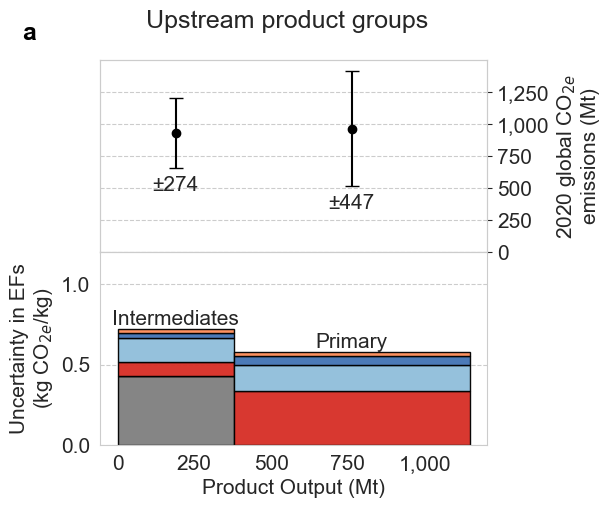

In [60]:
factors_int_used = factors_int_trial.set_index(['Region', 'COUNTRY/TERRITORY', 'Product group', 'PRODUCT', 'Gas', 'Product type', 'Year'])
## Intermediates plot
#for number, (category, factor_df) in enumerate(zip(['Intermediates', 'Downstream'], [factors_acc, factors_ds_acc]):
## Get total vals
#factors_df = factors.copy()
# category = 'Intermediates'
# colors = ['#D3D3D3', '#D1B26F', '#E66070', '#E6A730', '#6EE588', '#498DE6']
# colors = ['#D3D3D3', 'darkgreen', '#E66070', '#E6A730', '#6EE588', '#498DE6']
colors_used = ['grey', 'k'] + colors

ylabel1, ylabel2 = 'Uncertainty in EFs\n', '2020 global CO$_{2e}$\nemissions'
columns = ['Primary chemicals', 'Intermediates', 'Feedstock', 'Indirect Energy Use', 'Direct Energy Use', 'Direct Process']

## Create production values figure
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [1, 1]}, figsize=[5,5], facecolor='white')

width=0.7
fontsize=15

prod_grouping, type_grouping = create_groupings(factors_int_used, grouped_prod_trial, 'y', group_type='Product group', columns=columns)
prod_grouping_s, type_grouping_s = create_groupings(factors_int_used, grouped_prod_trial, 'sigma_y', group_type='Product group', columns=columns)

if category == 'Intermediates':
    upt_vals = []
    for num, i in enumerate(type_grouping['Product group']):
        upt_vals = upt_vals+[type_grouping.iloc[num]['Total_val']-type_grouping.iloc[num][i]]

    type_grouping['Total_val'] = upt_vals

df_tot = filter_df(type_grouping, ['Product type'], [category]).sort_values('Total_factor', ascending=False)
df_tot['Product group'] = df_tot['Product group'].replace({'Solvents, additives & explosives':'S,A,E', 'Thermoplastics': 'TP', 'Thermosets, fibre & elastomers':'TS', 'Other downstream':'O'})

## Plot uncertainty boxes
ax = axs[1]
axs[1].grid(False)

df = filter_df(type_grouping_s, ['Product type'], [category]).sort_values('Total_factor', ascending=False)
# df['Product group'] = df['Product group'].replace({'Solvents, additives & explosives':'S,A,E', 'Thermoplastics': 'TP', 'Thermosets, fibre & elastomers':'TS', 'Other downstream':'O'})
df['Cml'] = df[year].cumsum()
df['Centres'] = df['Cml']-df[year]/2
ax = plot_boxes(df, columns, err=False, firstword=True, colors=colors_used, ylabel1=ylabel1, ylabel2=ylabel2, plot_bars=False)

ax.set_ylim([0,1.2])# if number == 0 else 0.5])

## Create top bars
ax2 = axs[0].twinx()
axs[0].grid(False)
df = df.merge(df_tot, on='Product group', how='left')
scale_factor=1/1000
unit='Mt'
p2 = ax2.errorbar(df['Centres']*scale_factor, df['Total_val_y']*scale_factor, yerr=df['Total_val_x']*scale_factor, fmt='o', color='k', ecolor='k', capsize=5, label='Total')
ax2.set_ylim(bottom=0)
ax2.set_ylabel(ylabel2+' ('+unit+')')
ax2.grid(axis='y', linestyle='dashed', zorder=0)
axs[0].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

for i, (xi, yi, y_err_i) in enumerate(zip(df['Centres']*scale_factor, df['Total_val_y']*scale_factor, df['Total_val_x']*scale_factor)):
    if yi < 100:
        ax2.text(xi, yi + y_err_i + 50, '±'+f"{y_err_i:.0f}" if y_err_i > 9.49 else '±'+f"{y_err_i:.1f}", ha='center')
    else:
        ax2.text(xi, yi - y_err_i-175, '±'+f"{y_err_i:.0f}" if y_err_i > 9.49 else '±'+f"{y_err_i:.1f}", ha='center') #
ax2.set_ylim([0, 1500])
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_yticks([0,250,500,750,1000,1250])

fig.suptitle('Upstream product groups')

w, h, fs = -0.2, 1.2, 18
ax2.text(w, h, 'a', transform = ax2.transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

In [61]:
fig.savefig(output_path+'Figure_5a.png', bbox_inches='tight',dpi=300)
fig.savefig(output_path+'Figure_5a.eps', format='eps', bbox_inches='tight',dpi=300)

#fig.savefig('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/production_vs_emissions_uncert_intermeds_update.png', bbox_inches='tight', dpi=150)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [63]:
## Add together organic chemicals and other intermediates product groups into a single group called Intermediates for factor_ds
factors_ds_trial = factors_ds.reset_index()
factors_ds_trial['Product group'] = factors_ds_trial['Product group'].replace({'Organic chemicals':'Intermediates', 'Other intermediates':'Intermediates'})
factors_ds_trial = factors_ds_trial.groupby(['Region', 'COUNTRY/TERRITORY', 'Product group', 'PRODUCT', 'Gas', 'Product type', 'Year']).sum()

## Add ('y', 'organic chemicals') and ('y', 'other intermediates') columns into ('y', 'Intermediates') column and ('sigma_y', 'organic chemicals') and ('sigma_y', 'other intermediates') columns into ('sigma_y', 'Intermediates') column
factors_ds_trial['y', 'Intermediates'] = factors_ds_trial['y', 'Organic chemicals']+factors_ds_trial['y', 'Other intermediates']
factors_ds_trial['sigma_y', 'Intermediates'] = factors_ds_trial['sigma_y', 'Organic chemicals']+factors_ds_trial['sigma_y', 'Other intermediates']

# Remove the organic chemicals and other intermediates columns
factors_ds_trial = factors_ds_trial.drop(columns=[('y', 'Organic chemicals'), ('sigma_y', 'Organic chemicals'), ('y', 'Other intermediates'), ('sigma_y', 'Other intermediates')])

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_14332/4131558572.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  factors_ds_trial = factors_ds_trial.groupby(['Region', 'COUNTRY/TERRITORY', 'Product group', 'PRODUCT', 'Gas', 'Product type', 'Year']).sum()


In [64]:
grouped_prod

,PRODUCT,2020,Unnamed: 3
Product group,,,
N-fertilisers,AMMONIUM NITRATEAMMONIUM SULPHATECALCIUM AMMON...,275701.5,0
Organic chemicals,"1,4-BUTANEDIOL2-ETHYLHEXANOLACETALDEHYDEACETIC...",354849.0,80% sure
Other downstream,DMT,1129.0,0
Other intermediates,MDIPHTHALIC ANHYDRIDEPOLYETHER POLYOLSPROPYLEN...,23115.0,or Organic chemicals
Primary chemicals,AMMONIABENZENEBUTADIENEETHYLENEMETHANOLMIXED X...,769402.2,0
"Solvents, additives & explosives",BUTYL ACETATEISOBUTANOLISOPROPANOLLUBEN-BUTANOL,8766.0,0
Thermoplastics,ABSEVA COPOLYMERSEXPANDABLE PSHDPELDPELLDPEPAM...,399133.0,0
"Thermosets, fibre & elastomers",BUTYL RUBBEREPOXY RESINSNB COPOLYMERSPOLYAMIDE...,89611.0,0


In [65]:
## Add together organic chemicals and other intermediates product groups into a single group called Intermediates for grouped_prod
grouped_prod_trial = grouped_prod.reset_index()
grouped_prod_trial['Product group'] = grouped_prod_trial['Product group'].replace({'Organic chemicals':'Intermediates', 'Other intermediates':'Intermediates'})
grouped_prod_trial = grouped_prod_trial[['Product group', '2020']].groupby(['Product group']).sum()

In [66]:
tot_ints = factors_int_trial[factors_int_trial['Product group']=='Intermediates']['y'].sum().sum()
tot_primary = factors_int_trial[factors_int_trial['Product group']=='Primary chemicals']['y'].sum().sum()-factors_int_trial[factors_int_trial['Product group']=='Intermediates']['y'].sum()['Primary chemicals']

sigma_ints_conversion = factors_int_trial[factors_int_trial['Product group']=='Intermediates']['sigma_y'].sum().sum()/factors_int_trial[factors_int_trial['Product group']=='Intermediates']['y'].sum().sum()
sigma_primary_conversion = factors_int_trial[factors_int_trial['Product group']=='Primary chemicals']['sigma_y'].sum().sum()/factors_int_trial[factors_int_trial['Product group']=='Primary chemicals']['y'].sum().sum()

remain_ints = tot_ints-factors_ds_trial.sum()[('y','Intermediates')]
remain_prim = tot_primary-factors_ds_trial.sum()[('y','Primary chemicals')]

# error_ints = sigma_ints-factors_ds_trial.sum()[('sigma_y','Intermediates')]
# error_prim = sigma_primary-factors_ds_trial.sum()[('sigma_y','Primary chemicals')]

# Add remain_ints to downstream intermediates columns
df = factors_ds_trial.reset_index()
df.loc[4,('y','Intermediates')] = df.loc[4,('y','Intermediates')]+remain_ints
df.loc[4,('sigma_y','Intermediates')] = df.loc[4,('sigma_y','Intermediates')]+sigma_ints_conversion*remain_ints
df.loc[4, ('y', 'Primary chemicals')] = df.loc[4, ('y', 'Primary chemicals')] + remain_prim
df.loc[4, ('sigma_y', 'Primary chemicals')] = df.loc[4, ('sigma_y', 'Primary chemicals')] + sigma_primary_conversion*remain_prim

In [67]:
factors_ds_trial = df.set_index(['Region', 'COUNTRY/TERRITORY', 'Product group', 'PRODUCT', 'Gas', 'Product type', 'Year'])

In [68]:
other_produced = (remain_ints/tot_ints)*grouped_prod_trial.loc['Intermediates', '2020']+(remain_prim/tot_primary)*grouped_prod_trial.loc['Primary chemicals', '2020']
grouped_prod_trial.loc['Other downstream', '2020'] = grouped_prod_trial.loc['Other downstream', '2020']+other_produced

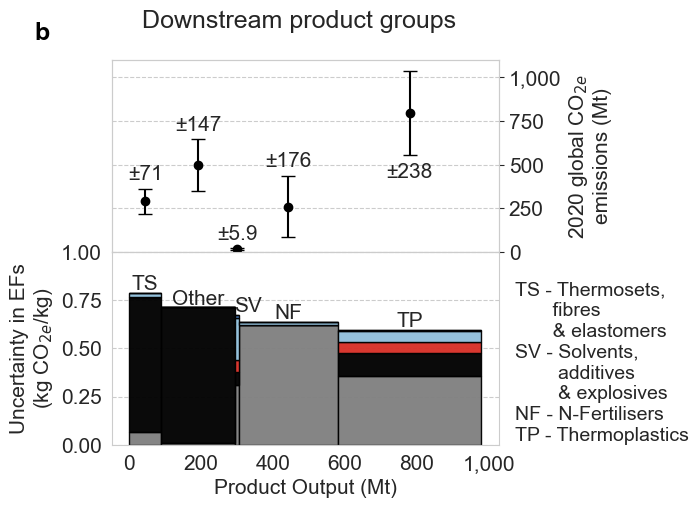

In [70]:
## Downstream plot
## Get total vals
factors_df = factors_ds_trial.copy()
category = 'Downstream'

ylabel1, ylabel2 = 'Uncertainty in EFs\n', '2020 global CO$_{2e}$\nemissions'
columns = ['Primary chemicals', 'Intermediates', 'Feedstock', 'Indirect Energy Use', 'Direct Energy Use', 'Direct Process']
colors = ['grey','k'] + colors#['#D3D3D3', 'darkgreen', '#E66070', '#E6A730', '#6EE588', '#498DE6']


## Create production values figure
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [1, 1]}, figsize=[5,5], facecolor='white')

width=0.7
fontsize=15

prod_grouping, type_grouping = create_groupings(factors_ds_trial, grouped_prod_trial, 'y', group_type='Product group', columns=columns)
prod_grouping_s, type_grouping_s = create_groupings(factors_ds_trial, grouped_prod_trial, 'sigma_y', group_type='Product group', columns=columns)

if category == 'Intermediates':
    upt_vals = []
    for num, i in enumerate(type_grouping['Product group']):
        upt_vals = upt_vals+[type_grouping.iloc[num]['Total_val']-type_grouping.iloc[num][i]]

    type_grouping['Total_val'] = upt_vals

df_tot = filter_df(type_grouping, ['Product type'], [category]).sort_values('Total_factor', ascending=False)
df_tot['Product group'] = df_tot['Product group'].replace({'Solvents, additives & explosives':'SV', 'Thermoplastics': 'TP', 'Thermosets, fibre & elastomers':'TS', 'Other downstream':'Other', 'N-fertilisers':'NF'})

## Plot uncertainty boxes
ax = axs[1]
axs[1].grid(False)

df = filter_df(type_grouping_s, ['Product type'], [category]).sort_values('Total_factor', ascending=False)
df['Product group'] = df['Product group'].replace({'Solvents, additives & explosives':'SV', 'Thermoplastics': 'TP', 'Thermosets, fibre & elastomers':'TS', 'Other downstream':'Other', 'N-fertilisers':'NF'})
#df = df[df['Product group']!='O']
df['Cml'] = df[year].cumsum()
df['Centres'] = df['Cml']-df[year]/2
ax = plot_boxes(df, columns, err=False, firstword=True, colors=colors, ylabel1=ylabel1, ylabel2=ylabel2, plot_bars=False, labelling=False)

for i, (xi, yi, prod) in enumerate(zip(df['Centres']*scale_factor, df['Total_factor'], df['Product group'])):
    if i==2:
        x_val = xi+30
    elif i==6:
        x_val = xi+10
    else: x_val = xi
    ax.text(x_val, yi + 0.015, prod, ha='center')

ax.set_ylim([0,1.0])

# Define the y-axis coordinates
y = np.array([0, 1, 4, 5])
x = np.array([0, 0, 0, 0])

## Create top bars
ax2 = axs[0].twinx()
axs[0].grid(False)
df = df.merge(df_tot, on='Product group', how='left')

scale_factor=1/1000
unit='Mt'
p2 = ax2.errorbar(df['Centres']*scale_factor, df['Total_val_y']*scale_factor, yerr=df['Total_val_x']*scale_factor, fmt='o', color='k', ecolor='k', capsize=5, label='Total')
ax2.set_ylim(bottom=0)
ax2.set_ylabel(ylabel2+' ('+unit+')')
ax2.grid(axis='y', linestyle='dashed', zorder=0)
axs[0].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

for i, (xi, yi, y_err_i) in enumerate(zip(df['Centres']*scale_factor, df['Total_val_y']*scale_factor, df['Total_val_x']*scale_factor)):
    if yi < 500:
        ax2.text(xi, yi + y_err_i + 50, '±'+f"{y_err_i:.0f}" if y_err_i > 9.49 else '±'+f"{y_err_i:.1f}", ha='center')
    else:
        ax2.text(xi, yi - y_err_i-135, '±'+f"{y_err_i:.0f}" if y_err_i > 9.49 else '±'+f"{y_err_i:.1f}", ha='center') #
ax2.set_ylim([0, 1100])
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_yticks([0,250,500,750,1000])
fig.suptitle('Downstream product groups')

fig.text(1.04, 0.85, 'TS - Thermosets,\n       fibres\n       & elastomers\nSV - Solvents,\n        additives\n        & explosives\nNF - N-Fertilisers\nTP - Thermoplastics',
         transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox={'boxstyle':'round', 'linestyle':'-', 'facecolor':'w', 'alpha':0.5})

w, h, fs = -0.2, 1.2, 18
ax2.text(w, h, 'b', transform = ax2.transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

handles, labels = ax.get_legend_handles_labels()

In [71]:
fig.savefig(output_path+'Figure_5b.png', bbox_inches='tight',dpi=300)
fig.savefig(output_path+'Figure_5b.eps', format='eps', bbox_inches='tight',dpi=300)

#fig.savefig('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/production_vs_emissions_uncert_downstream_update.png', bbox_inches='tight', dpi=150)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


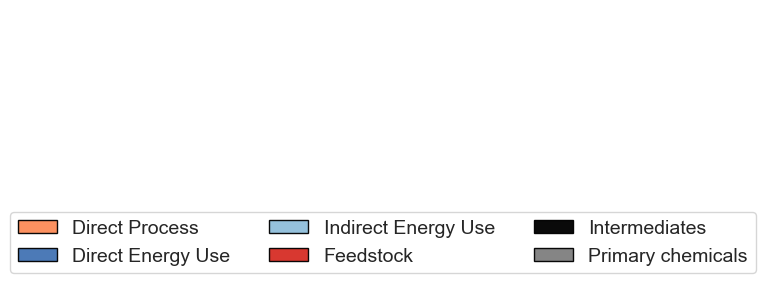

In [72]:
fig_leg = plt.figure(figsize=(5, 2))
ax_leg = fig_leg.add_subplot(111)

# Create a legend
ax_leg.legend(handles[::-1], labels[::-1], bbox_to_anchor=[1.2, -0.25], fontsize=fontsize-1, ncol=3)

# Remove the axis and ticks
ax_leg.axis('off')

fig_leg.savefig(output_path+'Figure_5_legend.png', bbox_inches='tight',dpi=300)
fig_leg.savefig(output_path+'Figure_5_legend.eps', format='eps', bbox_inches='tight',dpi=300)
# Save the legend as an image
#fig_leg.savefig('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/production_vs_emissions_uncert_legend.png', bbox_inches='tight', dpi=150)

In [167]:
ints = sum(df[['Organic chemicals_x', 'Primary chemicals_x', 'Other intermediates_x']].sum(axis=1)*df['2020_y'])
tot = sum(df[['Direct Process_x', 'Feedstock_x', 'Indirect Energy Use_x', 'Direct Energy Use_x', 'Organic chemicals_x', 'Primary chemicals_x', 'Other intermediates_x']].sum(axis=1)*df['2020_y'])
ints/tot

0.8063199889067502

C:\Users\lukec\AppData\Local\Temp/ipykernel_8344/4288793956.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  combined_fig.tight_layout()


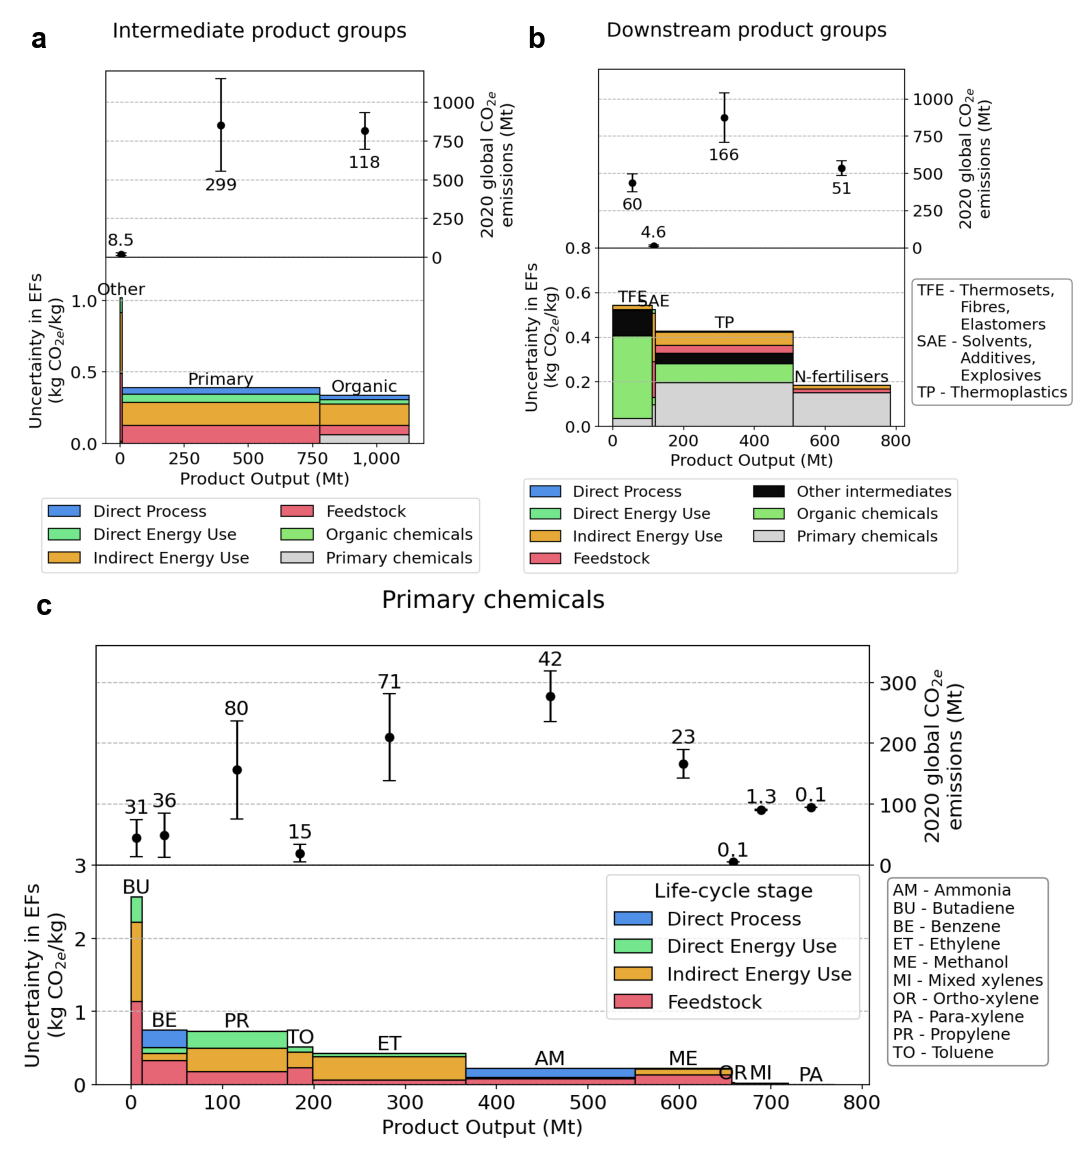

In [128]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Read in the three figures
fig1 = plt.imread('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/production_vs_emissions_uncert_individual.png')
fig2 = plt.imread('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/production_vs_emissions_uncert_intermeds.png')
fig3 = plt.imread('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/production_vs_emissions_uncert_downstream.png')

# Create a new figure
combined_fig = plt.figure(figsize=[12,10], dpi=150)
gs = gridspec.GridSpec(2, 2, hspace=0, wspace=-0.4)

# Add subplots to the combined figure
ax1 = combined_fig.add_subplot(gs[1,:])
ax1.imshow(fig1)
ax1.axis('off')

ax2 = combined_fig.add_subplot(gs[0])
ax2.imshow(fig2)
ax2.axis('off')

ax3 = combined_fig.add_subplot(gs[1])
ax3.imshow(fig3)
ax3.axis('off')

# Set the overall title for the combined figure
fs=14

ax1.text(w, h, 'c', transform = ax1.transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
ax2.text(w, h, 'a', transform = ax2.transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
ax3.text(w, h, 'b', transform = ax3.transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

# Adjust the spacing between subplots
combined_fig.tight_layout()


In [129]:
combined_fig.savefig('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/production_vs_emissions_uncert_combined.png', bbox_inches='tight', dpi=150)

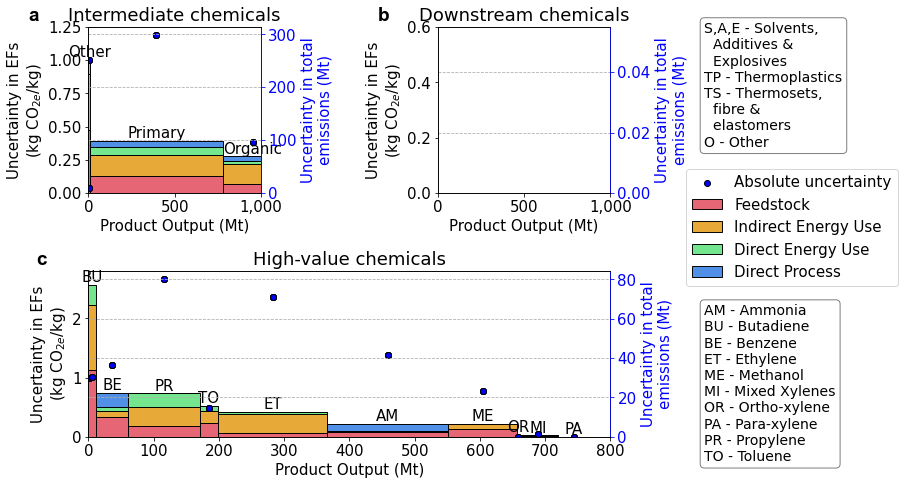

In [16]:
## Create production values figure
fig = plt.figure(figsize=[10,7], facecolor='white')
width=0.7
fontsize=15
axs = [fig.add_subplot(2,2,1), fig.add_subplot(2,2,2), fig.add_subplot(2,2,(3,4))]
ylabel1, ylabel2 = 'Uncertainty in EFs\n', 'Uncertainty in total\nemissions'

#prod_grouping_s, type_grouping_s = create_groupings(factors, 'sigma_y')
#type_grouping.sort_values(['Product type','Total'], ascending=False, inplace=True)

for i, filt in enumerate(['Intermediates', 'Downstream']):
    df = filter_df(type_grouping_s, ['Product type'], [filt]).sort_values('Total_factor', ascending=False)
    df['Product group'] = df['Product group'].replace({'Solvents, additives & explosives':'S,A,E', 'Thermoplastics': 'TP', 'Thermosets, fibre & elastomers':'TS', 'Other downstream':'O'})
    df['Cml'] = df[year].cumsum()
    df['Centres'] = df['Cml']-df[year]/2
    ax = axs[i]
    axs[i] = plot_boxes(df, columns, err=False, firstword=True, colors=colors, ylabel1=ylabel1, ylabel2=ylabel2)

# Individual emissions
ind_prods = filter_df(prod_grouping_s, ['PRODUCT'], [used_prods]).sort_values('Total_factor', ascending=False)

ind_prods['Cml'] = ind_prods[year].cumsum()
ind_prods['Centres'] = ind_prods['Cml']-ind_prods[year]/2
ax = axs[2]
ax = plot_boxes(ind_prods, columns, plot_col='PRODUCT', err=False, colors=colors, ylabel1=ylabel1, ylabel2=ylabel2)

# for ax in axs:
#     ax.set_ylabel('Unit emissions\n(kg CO$_{2}$e/kg)')

axs[0].set_title('Intermediate chemicals')
axs[0].set_xlim([0,1000])
axs[0].set_ylim([0,1.25])
axs[1].set_title('Downstream chemicals')
axs[1].set_xlim([0,1000])
axs[1].set_ylim([0,0.6])
axs[2].set_title('High-value chemicals')
axs[2].set_xlim([0,800])
axs[2].set_ylim([0,2.8])
#axs[0].legend(bbox_to_anchor=[1.5, 1.1])
# axs[2].text(1.1, 0.8, 'AM - AMMONIA\nBU - BUTADIENE\nBE - BENZENE\nET - ETHYLENE\nME - METHANOL\nMI - MIXED XYLENES\nOR - ORTHO-XYLENE\nPA - PARA-XYLENE\nPR - PROPYLENE\nTO - TOLUENE', transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox={'boxstyle':'round', 'linestyle':'-', 'facecolor':'w', 'alpha':0.5})
fig.text(1.18, 2.5, 'S,A,E - Solvents,\n  Additives &\n  Explosives\nTP - Thermoplastics\nTS - Thermosets,\n  fibre &\n  elastomers\nO - Other',
         transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox={'boxstyle':'round', 'linestyle':'-', 'facecolor':'w', 'alpha':0.5})

fig.text(1.18, 0.8, 'AM - Ammonia\nBU - Butadiene\nBE - Benzene\nET - Ethylene\nME - Methanol\nMI - Mixed Xylenes\nOR - Ortho-xylene\nPA - Para-xylene\nPR - Propylene\nTO - Toluene', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox={'boxstyle':'round', 'linestyle':'-', 'facecolor':'w', 'alpha':0.5})

handles, l = axs[2].get_legend_handles_labels()
fig.legend(handles=handles[3:], labels=l[3:], bbox_to_anchor=[1.28, 0.66])

w=-0.35
h=1.12
fontsize = fontsize+4
axs[0].text(w, h, 'a', transform = axs[0].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[1].text(w, h, 'b', transform = axs[1].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[2].text(-0.1, h, 'c', transform = axs[2].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

fig.tight_layout()

In [57]:
filter_df(type_grouping_s, ['Product type'], ['Downstream'])

,Product type,Product group,Direct Energy Use,Direct Process,Feedstock,Indirect Energy Use,Organic chemicals,Other intermediates,Primary chemicals,2020,Total_val,Total_factor
0,Downstream,N-fertilisers,0.000565,7.259491e-03,0.042015,0.089325,0.000000,0.000000,0.000000,461094.7,64168.160741,0.139165
1,Downstream,Other downstream,0.000745,9.844796e-20,0.001078,0.007400,64.873746,0.000000,40.049878,8827.0,81.410093,0.009223
2,Downstream,"Solvents, additives & explosives",0.017645,0.000000e+00,0.161377,0.215189,72.620178,0.000000,964.226709,8766.0,3455.660660,0.394212
3,Downstream,Thermoplastics,0.006034,0.000000e+00,0.036573,0.057901,4072.755522,600.744155,16616.842278,388787.0,39076.268022,0.100508
4,Downstream,"Thermosets, fibre & elastomers",0.000167,2.632238e-20,0.004827,0.020943,4785.346014,422.438577,218.532172,105950.0,2748.010754,0.025937


In [51]:
# Save figure
fig.savefig('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/production_vs_uncertainties.png', bbox_inches='tight')